## Import Packages

In [51]:
import plotly.graph_objs as pgo
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

## Parse Data

In [71]:
# Parse training and test into data and labels
X_trO = pd.read_csv("trainEmployeeData.csv")
Y_tr = X_trO[['Attrition']]
X_tr = X_trO.drop(['Attrition','Unnamed: 0'], 1)
X_tr = X_tr.drop(['Over18'], axis=1)

X_testO = pd.read_csv("testEmployeeData.csv")
Y_test = X_testO[['Attrition', 'Unnamed: 0']]
X_test = X_testO.drop(['Attrition','Unnamed: 0'], 1)
X_test = X_test.drop(['Over18'], axis=1)

In [12]:
X_tr.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,Travel_Rarely,201,Research & Development,1,4,Life Sciences,1,517,2,...,2,80,1,8,5,3,5,2,1,2
1,32,Travel_Rarely,128,Research & Development,2,1,Technical Degree,1,362,4,...,4,80,0,9,5,3,6,2,0,4
2,48,Travel_Rarely,715,Research & Development,1,3,Life Sciences,1,1263,4,...,3,80,0,25,3,4,1,0,0,0
3,51,Travel_Rarely,432,Research & Development,9,4,Life Sciences,1,116,4,...,2,80,2,10,4,3,4,2,0,3
4,29,Travel_Rarely,726,Research & Development,29,1,Life Sciences,1,1859,4,...,4,80,2,11,3,3,7,0,1,6


In [13]:
Y_tr.head()

,Attrition
0,No
1,No
2,No
3,No
4,No


## Data Cleaning

In [15]:
# Check for any null values
total_data = pd.concat([X_trO,X_testO]).drop('Unnamed: 0', 1)
X_tr.isnull().any()

Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLifeBalance             False
YearsAtCompany

In [16]:
# We see no invalid data based off summary statistics
total_data.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,1024.865306,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,602.024335,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,491.250000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,1020.500000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,1555.750000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


In [17]:
def transformTrainData(data):
    categorical = []
    for col, value in data.iteritems():
        if value.dtype == 'object':
            categorical.append(col)
    numerical = data.columns.difference(categorical)
    data_cat = data[categorical]
    data_cat = pd.get_dummies(data_cat)
    data_num = data[numerical]
    return pd.concat([data_num, data_cat], axis=1)

def transformTestData(data):
    return data["Attrition"].apply(lambda x: 1 if x == "Yes" else 0)

tran_X_tr = transformTrainData(X_tr)
tran_X_test = transformTrainData(X_test)

tran_Y_tr = transformTestData(Y_tr)
tran_Y_test = transformTestData(Y_test)

tran_X_tr.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,42,201,1,4,1,517,2,95,3,1,...,0,0,0,0,0,1,0,0,1,0
1,32,128,2,1,1,362,4,84,2,2,...,0,0,0,0,0,0,0,1,1,0
2,48,715,1,3,1,1263,4,76,2,5,...,0,1,0,0,0,0,0,1,1,0
3,51,432,9,4,1,116,4,96,3,1,...,0,0,0,0,0,0,1,0,1,0
4,29,726,29,1,1,1859,4,93,1,2,...,0,0,0,0,0,1,0,0,1,0


## Random Forest Model

### Grid Search for Optimal Hyperparameter

In [27]:
param_grid = [
  {
      'n_estimators': [10, 20, 40, 80, 160], 
      'max_depth': [10, 20, 30, 40, 50, 55], 
      'max_features': ['sqrt', 'log2', 10]
  }
]

rfc = RandomForestClassifier(n_jobs=-1) 
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose = 1)

CV_rfc.fit(tran_X_tr, tran_Y_tr)

opt_parameters = CV_rfc.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.4min finished


In [28]:
opt_parameters

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}

In [83]:
dir(CV_rfc)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_fit',
 '_get_param_names',
 'best_estimator_',
 'best_params_',
 'best_score_',
 'cv',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'fit_params',
 'get_params',
 'grid_scores_',
 'iid',
 'inverse_transform',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'score',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [89]:
pd.DataFrame(CV_rfc.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'max_features': 'sqrt', 'max_depth': 10, 'n_e...",0.852041,"[0.843220338983, 0.83829787234, 0.863829787234..."
1,"{'max_features': 'sqrt', 'max_depth': 10, 'n_e...",0.861395,"[0.851694915254, 0.851063829787, 0.87234042553..."
2,"{'max_features': 'sqrt', 'max_depth': 10, 'n_e...",0.856293,"[0.851694915254, 0.863829787234, 0.86382978723..."
3,"{'max_features': 'sqrt', 'max_depth': 10, 'n_e...",0.853741,"[0.85593220339, 0.842553191489, 0.851063829787..."
4,"{'max_features': 'sqrt', 'max_depth': 10, 'n_e...",0.854592,"[0.843220338983, 0.855319148936, 0.86382978723..."
5,"{'max_features': 'log2', 'max_depth': 10, 'n_e...",0.857143,"[0.85593220339, 0.846808510638, 0.859574468085..."
6,"{'max_features': 'log2', 'max_depth': 10, 'n_e...",0.856293,"[0.847457627119, 0.868085106383, 0.86382978723..."
7,"{'max_features': 'log2', 'max_depth': 10, 'n_e...",0.852891,"[0.847457627119, 0.855319148936, 0.85957446808..."
8,"{'max_features': 'log2', 'max_depth': 10, 'n_e...",0.851190,"[0.847457627119, 0.855319148936, 0.85531914893..."
9,"{'max_features': 'log2', 'max_depth': 10, 'n_e...",0.852891,"[0.847457627119, 0.855319148936, 0.85957446808..."


### Rerun RF Model on Optimal Parameters 

In [38]:
rfc = RandomForestClassifier(max_depth = opt_parameters["max_depth"]
                        ,max_features = opt_parameters['max_features']
                        ,n_estimators = opt_parameters['n_estimators']
                        ,n_jobs = -1)

rfc_fit = rfc.fit(tran_X_tr,tran_Y_tr)

print("Training accuracy: ", rfc_fit.score(tran_X_tr, tran_Y_tr))
print("Test accuracy: ", rfc_fit.score(tran_X_test, tran_Y_test))

Training accuracy:  0.975340136054
Test accuracy:  0.860544217687


In [40]:
for name, importance in zip(list(tran_X_tr.columns.values), rfc.feature_importances_):
    print(name, "=", importance)

Age = 0.0575173813793
DailyRate = 0.050381753698
DistanceFromHome = 0.0370545247087
Education = 0.0219396130815
EmployeeCount = 0.0
EmployeeNumber = 0.0379315285853
EnvironmentSatisfaction = 0.0198887966648
HourlyRate = 0.033004053101
JobInvolvement = 0.0240540696439
JobLevel = 0.0240005904909
JobSatisfaction = 0.0247154814047
MonthlyIncome = 0.0895652325197
MonthlyRate = 0.0419356818189
NumCompaniesWorked = 0.030165914416
PercentSalaryHike = 0.0301164969992
PerformanceRating = 0.00295206349043
RelationshipSatisfaction = 0.0214684229089
StandardHours = 0.0
StockOptionLevel = 0.027100370381
TotalWorkingYears = 0.0457052192951
TrainingTimesLastYear = 0.0234494418055
WorkLifeBalance = 0.0202012324933
YearsAtCompany = 0.0349178667984
YearsInCurrentRole = 0.0178674232447
YearsSinceLastPromotion = 0.0176992458244
YearsWithCurrManager = 0.0377013386731
BusinessTravel_Non-Travel = 0.00169694145687
BusinessTravel_Travel_Frequently = 0.0123828095048
BusinessTravel_Travel_Rarely = 0.0056269574622

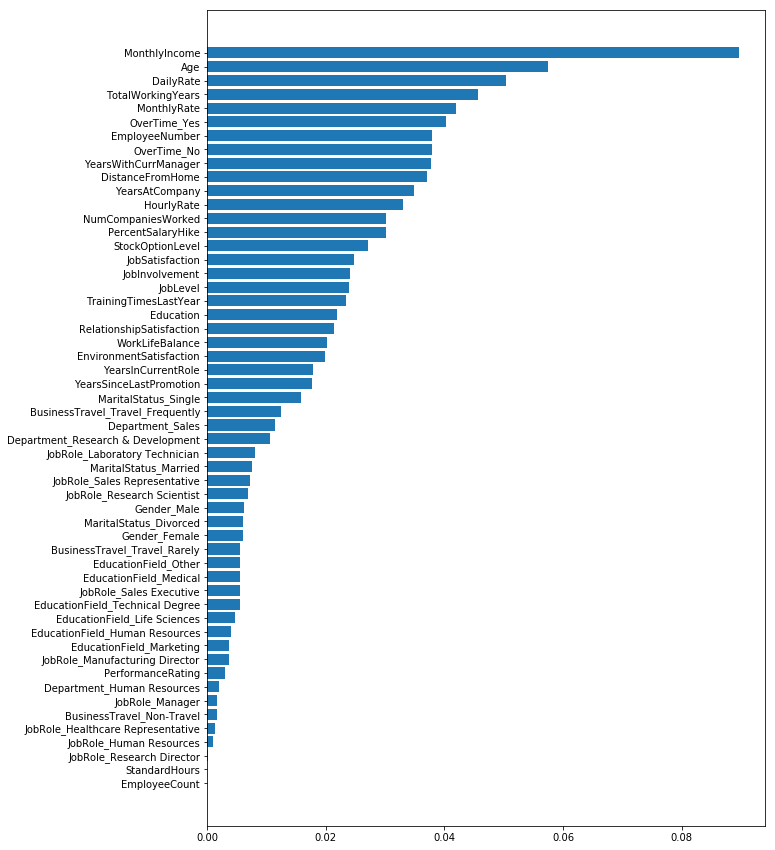

In [50]:
pp.figure(figsize = (10,15))
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    n = len(names)
    pp.barh(range(n), imp, align='center')
    pp.yticks(range(len(names)), names)
    pp.show()

features_names = tran_X_tr.columns.values
f_importances(rfc.feature_importances_, features_names)

In [80]:
import plotly.offline as py
from plotly.graph_objs import Scatter, Figure, Layout


# Scatter plot 
trace = pgo.Scatter(
    y = rfc.feature_importances_,
    x = features_names,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rfc.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features_names
)
data = [trace]

layout= pgo.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = pgo.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')


In [70]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(tran_X_tr,tran_Y_tr)


# convert_Y_data = pd.Series.to_frame(tran_Y_test)

# test = pd.concat(X_testO)

# Predicting results for test dataset
y_pred = decision_tree.predict(X_testO)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = attrition_final.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')

ValueError: could not convert string to float: 'Yes'